In [1]:
import os
import pandas as pd
import datetime
from matplotlib import pyplot
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LinearRegression
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import CuDNNLSTM
from keras.layers import CuDNNGRU
from keras.layers import RepeatVector
from keras.layers import TimeDistributed
from keras.layers import Bidirectional
from keras.layers import Lambda
from keras.layers import Dropout
from keras.layers import SimpleRNN
from keras.utils import generic_utils
from keras.utils import Sequence
from keras import regularizers
from keras import optimizers
from keras.callbacks import ModelCheckpoint
import tensorflow as tf
import numpy as np
import scipy 
import math
import h5py
import time
import copy
import sys
import feather
from sklearn.metrics import mean_absolute_error
from numpy.random import seed
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', -1)
seed(123)
from tensorflow import set_random_seed
set_random_seed(456)
np.set_printoptions(threshold=sys.maxsize)

Using TensorFlow backend.


In [2]:
import keras
print(os.getcwd())
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
tf.keras.backend.set_session(tf.Session(config=config))
from tensorflow.python.client import device_lib
#print(device_lib.list_local_devices())

/home/whsu014/dev/mlrig/Experiments


In [117]:
train_df = feather.read_dataframe("/home/whsu014/data/Post_PREDICT_Train_with_TRUE_85500inds.feather")
print(train_df.columns)
print(train_df.shape)
print("Number of inds in train:", train_df.shape[0]/29)
test_df = feather.read_dataframe("/home/whsu014/data/Post_PREDICT_Test_with_TRUE_9699inds.feather")
print(test_df.columns)
print(test_df.shape)
print("Number of inds in test:", test_df.shape[0]/29)

Index(['VSIMPLE_INDEX_MASTER', 'QUARTER', 'AGE', 'SEX', 'NZDEP', 'ETHN_1',
       'ETHN_2', 'ETHN_3', 'ETHN_4', 'ETHN_5',
       ...
       'PT_DIABETES_YR', 'PT_ATRIAL_FIBRILLATION', 'PT_IMP_FATAL_CVD',
       'TRUE_HDL', 'TRUE_LDL', 'TRUE_TRI', 'TRUE_TCL', 'TRUE_TCHDL',
       'TRUE_HBA1C', 'TRUE_EGFR'],
      dtype='object', length=190)
(2479500, 190)
Number of inds in train: 85500.0
Index(['VSIMPLE_INDEX_MASTER', 'QUARTER', 'AGE', 'SEX', 'NZDEP', 'ETHN_1',
       'ETHN_2', 'ETHN_3', 'ETHN_4', 'ETHN_5',
       ...
       'PT_DIABETES_YR', 'PT_ATRIAL_FIBRILLATION', 'PT_IMP_FATAL_CVD',
       'TRUE_HDL', 'TRUE_LDL', 'TRUE_TRI', 'TRUE_TCL', 'TRUE_TCHDL',
       'TRUE_HBA1C', 'TRUE_EGFR'],
      dtype='object', length=190)
(281271, 190)
Number of inds in test: 9699.0


In [118]:
# set length to 20
train_df = copy.deepcopy(train_df[train_df['QUARTER']>8])
test_df = copy.deepcopy(test_df[test_df['QUARTER']>8])
print(train_df.shape[0]/20)
print(test_df.shape[0]/20)
# remove true values
# remove QUARTER
train_df = train_df.drop(['QUARTER'], axis=1)
test_df = test_df.drop(['QUARTER'], axis=1)
train_v = copy.deepcopy(train_df.iloc[:, :-7].values)
test_v = copy.deepcopy(test_df.iloc[:, :-7].values)
print(train_v.shape)
print(train_v.shape[0]/20)
print(test_v.shape)
print(test_v.shape[0]/20)

85500.0
9699.0
(1710000, 182)
85500.0
(193980, 182)
9699.0


In [119]:
# standardise data
# z = (X - u)/s
# u is the mean of the training samples
# s is the standard devidation of the training samples
scaler = StandardScaler()
scaled_train = scaler.fit_transform(train_v) 
scaled_test = scaler.transform(test_v)

In [120]:
print('LL_PDC:', train_df.columns.get_loc('LL_PDC'))

LL_PDC: 28


In [121]:
def setup_xy(time_series, scaled_time_series, obs_steps):
    num_of_inds = time_series.shape[0]//20
    print("Number of inds:", num_of_inds)
    num_of_features = time_series.shape[1]
    print("Number of features:", num_of_features)
    x = np.empty((num_of_inds, obs_steps, num_of_features))
    # creating 2 binary vectors for softmax 
    # non-adherent and adherent
    y = np.empty((num_of_inds, 2))

    for i in range(num_of_inds):
        ind_v = time_series[(i*20):((i+1)*20), :]
        if (sum(ind_v[16:, 28])/4) >= 80:
            y[i, 0] = 0.0
            y[i, 1] = 1.0
        else:
            y[i, 0] = 1.0
            y[i, 1] = 0.0
        scaled_ind_v = scaled_time_series[(i*20):((i+1)*20), :]
        x[i] = scaled_ind_v[(16-obs_steps):16, :]
    return x, y

In [122]:
x_train, y_train = setup_xy(train_v, scaled_train, 16)
x_test, y_test = setup_xy(test_v, scaled_test, 16)
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

Number of inds: 85500
Number of features: 182
Number of inds: 9699
Number of features: 182
(85500, 16, 182)
(85500, 2)
(9699, 16, 182)
(9699, 2)


In [123]:
num_per_fold = x_train.shape[0]//10
print(num_per_fold)

8550


Train on 76950 samples, validate on 8550 samples
Epoch 1/500
 - 5s - loss: 0.7833 - acc: 0.5770 - val_loss: 0.7275 - val_acc: 0.6491

Epoch 00001: val_loss improved from inf to 0.72753, saving model to POST_val_weights1.hdf5
Epoch 2/500
 - 1s - loss: 0.6792 - acc: 0.7029 - val_loss: 0.6365 - val_acc: 0.7415

Epoch 00002: val_loss improved from 0.72753 to 0.63652, saving model to POST_val_weights1.hdf5
Epoch 3/500
 - 1s - loss: 0.5944 - acc: 0.7736 - val_loss: 0.5612 - val_acc: 0.7938

Epoch 00003: val_loss improved from 0.63652 to 0.56119, saving model to POST_val_weights1.hdf5
Epoch 4/500
 - 1s - loss: 0.5265 - acc: 0.8130 - val_loss: 0.4987 - val_acc: 0.8283

Epoch 00004: val_loss improved from 0.56119 to 0.49867, saving model to POST_val_weights1.hdf5
Epoch 5/500
 - 1s - loss: 0.4735 - acc: 0.8360 - val_loss: 0.4538 - val_acc: 0.8444

Epoch 00005: val_loss improved from 0.49867 to 0.45381, saving model to POST_val_weights1.hdf5
Epoch 6/500
 - 1s - loss: 0.4373 - acc: 0.8496 - val_lo

 - 1s - loss: 0.3228 - acc: 0.8739 - val_loss: 0.3269 - val_acc: 0.8745

Epoch 00046: val_loss improved from 0.32704 to 0.32687, saving model to POST_val_weights1.hdf5
Epoch 47/500
 - 1s - loss: 0.3227 - acc: 0.8738 - val_loss: 0.3268 - val_acc: 0.8743

Epoch 00047: val_loss improved from 0.32687 to 0.32676, saving model to POST_val_weights1.hdf5
Epoch 48/500
 - 1s - loss: 0.3225 - acc: 0.8738 - val_loss: 0.3264 - val_acc: 0.8743

Epoch 00048: val_loss improved from 0.32676 to 0.32643, saving model to POST_val_weights1.hdf5
Epoch 49/500
 - 1s - loss: 0.3223 - acc: 0.8738 - val_loss: 0.3263 - val_acc: 0.8747

Epoch 00049: val_loss improved from 0.32643 to 0.32633, saving model to POST_val_weights1.hdf5
Epoch 50/500
 - 1s - loss: 0.3221 - acc: 0.8738 - val_loss: 0.3262 - val_acc: 0.8739

Epoch 00050: val_loss improved from 0.32633 to 0.32624, saving model to POST_val_weights1.hdf5
Epoch 51/500
 - 1s - loss: 0.3220 - acc: 0.8738 - val_loss: 0.3259 - val_acc: 0.8743

Epoch 00051: val_loss 

 - 1s - loss: 0.3177 - acc: 0.8746 - val_loss: 0.3225 - val_acc: 0.8730

Epoch 00094: val_loss improved from 0.32249 to 0.32248, saving model to POST_val_weights1.hdf5
Epoch 95/500
 - 1s - loss: 0.3176 - acc: 0.8746 - val_loss: 0.3224 - val_acc: 0.8735

Epoch 00095: val_loss improved from 0.32248 to 0.32240, saving model to POST_val_weights1.hdf5
Epoch 96/500
 - 1s - loss: 0.3177 - acc: 0.8745 - val_loss: 0.3223 - val_acc: 0.8731

Epoch 00096: val_loss improved from 0.32240 to 0.32234, saving model to POST_val_weights1.hdf5
Epoch 97/500
 - 1s - loss: 0.3176 - acc: 0.8745 - val_loss: 0.3223 - val_acc: 0.8733

Epoch 00097: val_loss improved from 0.32234 to 0.32233, saving model to POST_val_weights1.hdf5
Epoch 98/500
 - 1s - loss: 0.3175 - acc: 0.8746 - val_loss: 0.3223 - val_acc: 0.8731

Epoch 00098: val_loss improved from 0.32233 to 0.32232, saving model to POST_val_weights1.hdf5
Epoch 99/500
 - 1s - loss: 0.3174 - acc: 0.8745 - val_loss: 0.3222 - val_acc: 0.8737

Epoch 00099: val_loss 


Epoch 00144: val_loss improved from 0.32080 to 0.32064, saving model to POST_val_weights1.hdf5
Epoch 145/500
 - 1s - loss: 0.3157 - acc: 0.8748 - val_loss: 0.3208 - val_acc: 0.8727

Epoch 00145: val_loss did not improve from 0.32064
Epoch 146/500
 - 1s - loss: 0.3156 - acc: 0.8749 - val_loss: 0.3207 - val_acc: 0.8730

Epoch 00146: val_loss did not improve from 0.32064
Epoch 147/500
 - 1s - loss: 0.3157 - acc: 0.8747 - val_loss: 0.3207 - val_acc: 0.8726

Epoch 00147: val_loss did not improve from 0.32064
Epoch 148/500
 - 1s - loss: 0.3156 - acc: 0.8748 - val_loss: 0.3207 - val_acc: 0.8730

Epoch 00148: val_loss did not improve from 0.32064
Epoch 149/500
 - 1s - loss: 0.3156 - acc: 0.8747 - val_loss: 0.3207 - val_acc: 0.8732

Epoch 00149: val_loss did not improve from 0.32064
Epoch 150/500
 - 1s - loss: 0.3156 - acc: 0.8748 - val_loss: 0.3206 - val_acc: 0.8730

Epoch 00150: val_loss improved from 0.32064 to 0.32061, saving model to POST_val_weights1.hdf5
Epoch 151/500
 - 1s - loss: 0.31

 - 1s - loss: 0.3149 - acc: 0.8749 - val_loss: 0.3199 - val_acc: 0.8727

Epoch 00198: val_loss did not improve from 0.31980
Epoch 199/500
 - 1s - loss: 0.3148 - acc: 0.8748 - val_loss: 0.3199 - val_acc: 0.8729

Epoch 00199: val_loss did not improve from 0.31980
Epoch 200/500
 - 1s - loss: 0.3147 - acc: 0.8749 - val_loss: 0.3198 - val_acc: 0.8729

Epoch 00200: val_loss improved from 0.31980 to 0.31976, saving model to POST_val_weights1.hdf5
Epoch 201/500
 - 1s - loss: 0.3149 - acc: 0.8748 - val_loss: 0.3199 - val_acc: 0.8726

Epoch 00201: val_loss did not improve from 0.31976
Epoch 202/500
 - 1s - loss: 0.3147 - acc: 0.8749 - val_loss: 0.3198 - val_acc: 0.8729

Epoch 00202: val_loss did not improve from 0.31976
Epoch 203/500
 - 1s - loss: 0.3147 - acc: 0.8748 - val_loss: 0.3198 - val_acc: 0.8727

Epoch 00203: val_loss did not improve from 0.31976
Epoch 204/500
 - 1s - loss: 0.3148 - acc: 0.8749 - val_loss: 0.3198 - val_acc: 0.8727

Epoch 00204: val_loss did not improve from 0.31976
Epoc

 - 1s - loss: 0.3143 - acc: 0.8750 - val_loss: 0.3194 - val_acc: 0.8727

Epoch 00253: val_loss did not improve from 0.31932
Epoch 254/500
 - 1s - loss: 0.3143 - acc: 0.8750 - val_loss: 0.3193 - val_acc: 0.8730

Epoch 00254: val_loss did not improve from 0.31932
Epoch 255/500
 - 1s - loss: 0.3144 - acc: 0.8749 - val_loss: 0.3195 - val_acc: 0.8726

Epoch 00255: val_loss did not improve from 0.31932
Epoch 256/500
 - 1s - loss: 0.3142 - acc: 0.8750 - val_loss: 0.3193 - val_acc: 0.8726

Epoch 00256: val_loss did not improve from 0.31932
Epoch 257/500
 - 1s - loss: 0.3143 - acc: 0.8749 - val_loss: 0.3195 - val_acc: 0.8727

Epoch 00257: val_loss did not improve from 0.31932
Epoch 258/500
 - 1s - loss: 0.3144 - acc: 0.8750 - val_loss: 0.3193 - val_acc: 0.8727

Epoch 00258: val_loss did not improve from 0.31932
Epoch 259/500
 - 1s - loss: 0.3143 - acc: 0.8750 - val_loss: 0.3194 - val_acc: 0.8727

Epoch 00259: val_loss did not improve from 0.31932
Epoch 260/500
 - 1s - loss: 0.3143 - acc: 0.8749

 - 1s - loss: 0.3140 - acc: 0.8750 - val_loss: 0.3191 - val_acc: 0.8730

Epoch 00311: val_loss did not improve from 0.31906
Epoch 312/500
 - 1s - loss: 0.3141 - acc: 0.8750 - val_loss: 0.3190 - val_acc: 0.8735

Epoch 00312: val_loss improved from 0.31906 to 0.31905, saving model to POST_val_weights1.hdf5
Epoch 313/500
 - 1s - loss: 0.3140 - acc: 0.8750 - val_loss: 0.3191 - val_acc: 0.8733

Epoch 00313: val_loss did not improve from 0.31905
Epoch 314/500
 - 1s - loss: 0.3141 - acc: 0.8750 - val_loss: 0.3192 - val_acc: 0.8732

Epoch 00314: val_loss did not improve from 0.31905
Epoch 315/500
 - 1s - loss: 0.3141 - acc: 0.8750 - val_loss: 0.3193 - val_acc: 0.8730

Epoch 00315: val_loss did not improve from 0.31905
Epoch 316/500
 - 1s - loss: 0.3139 - acc: 0.8749 - val_loss: 0.3190 - val_acc: 0.8735

Epoch 00316: val_loss improved from 0.31905 to 0.31904, saving model to POST_val_weights1.hdf5
Epoch 317/500
 - 1s - loss: 0.3140 - acc: 0.8750 - val_loss: 0.3191 - val_acc: 0.8731

Epoch 00317


Epoch 00368: val_loss did not improve from 0.31886
Epoch 369/500
 - 1s - loss: 0.3138 - acc: 0.8750 - val_loss: 0.3190 - val_acc: 0.8732

Epoch 00369: val_loss did not improve from 0.31886
Epoch 370/500
 - 1s - loss: 0.3137 - acc: 0.8751 - val_loss: 0.3191 - val_acc: 0.8731

Epoch 00370: val_loss did not improve from 0.31886
Epoch 371/500
 - 1s - loss: 0.3137 - acc: 0.8750 - val_loss: 0.3191 - val_acc: 0.8733

Epoch 00371: val_loss did not improve from 0.31886
Epoch 372/500
 - 1s - loss: 0.3139 - acc: 0.8752 - val_loss: 0.3190 - val_acc: 0.8729

Epoch 00372: val_loss did not improve from 0.31886
Epoch 373/500
 - 1s - loss: 0.3137 - acc: 0.8751 - val_loss: 0.3189 - val_acc: 0.8731

Epoch 00373: val_loss did not improve from 0.31886
Epoch 374/500
 - 1s - loss: 0.3137 - acc: 0.8751 - val_loss: 0.3189 - val_acc: 0.8735

Epoch 00374: val_loss did not improve from 0.31886
Epoch 375/500
 - 1s - loss: 0.3137 - acc: 0.8751 - val_loss: 0.3189 - val_acc: 0.8733

Epoch 00375: val_loss did not imp


Epoch 00425: val_loss did not improve from 0.31874
Epoch 426/500
 - 1s - loss: 0.3135 - acc: 0.8749 - val_loss: 0.3187 - val_acc: 0.8732

Epoch 00426: val_loss improved from 0.31874 to 0.31873, saving model to POST_val_weights1.hdf5
Epoch 427/500
 - 1s - loss: 0.3135 - acc: 0.8748 - val_loss: 0.3188 - val_acc: 0.8732

Epoch 00427: val_loss did not improve from 0.31873
Epoch 428/500
 - 1s - loss: 0.3135 - acc: 0.8748 - val_loss: 0.3189 - val_acc: 0.8733

Epoch 00428: val_loss did not improve from 0.31873
Epoch 429/500
 - 1s - loss: 0.3135 - acc: 0.8749 - val_loss: 0.3188 - val_acc: 0.8735

Epoch 00429: val_loss did not improve from 0.31873
Epoch 430/500
 - 1s - loss: 0.3135 - acc: 0.8749 - val_loss: 0.3188 - val_acc: 0.8735

Epoch 00430: val_loss did not improve from 0.31873
Epoch 431/500
 - 1s - loss: 0.3136 - acc: 0.8747 - val_loss: 0.3188 - val_acc: 0.8736

Epoch 00431: val_loss did not improve from 0.31873
Epoch 432/500
 - 1s - loss: 0.3136 - acc: 0.8748 - val_loss: 0.3188 - val_ac


Epoch 00483: val_loss did not improve from 0.31859
Epoch 484/500
 - 1s - loss: 0.3134 - acc: 0.8750 - val_loss: 0.3188 - val_acc: 0.8736

Epoch 00484: val_loss did not improve from 0.31859
Epoch 485/500
 - 1s - loss: 0.3134 - acc: 0.8749 - val_loss: 0.3186 - val_acc: 0.8736

Epoch 00485: val_loss improved from 0.31859 to 0.31859, saving model to POST_val_weights1.hdf5
Epoch 486/500
 - 1s - loss: 0.3134 - acc: 0.8748 - val_loss: 0.3188 - val_acc: 0.8735

Epoch 00486: val_loss did not improve from 0.31859
Epoch 487/500
 - 1s - loss: 0.3134 - acc: 0.8749 - val_loss: 0.3188 - val_acc: 0.8736

Epoch 00487: val_loss did not improve from 0.31859
Epoch 488/500
 - 1s - loss: 0.3134 - acc: 0.8749 - val_loss: 0.3187 - val_acc: 0.8735

Epoch 00488: val_loss did not improve from 0.31859
Epoch 489/500
 - 1s - loss: 0.3135 - acc: 0.8748 - val_loss: 0.3189 - val_acc: 0.8736

Epoch 00489: val_loss did not improve from 0.31859
Epoch 490/500
 - 1s - loss: 0.3134 - acc: 0.8749 - val_loss: 0.3187 - val_ac

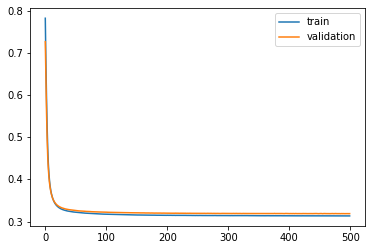

(9699, 2)


In [124]:
from numpy.random import seed
seed(1)
from tensorflow import set_random_seed
set_random_seed(1)

units = 2
batch_s = 2048

L2_1 = 0.008865712826436294
#L2_2 = 2.039614823469726e-05

for f in range(1):#10
    #start = f*num_per_fold
    end = (f+1)*num_per_fold
    train1_x = x_train[:end, ]
    train2_x = x_train[end:, ]
    train_x_lstm = np.append(train2_x, train1_x, axis=0) 
    train1_y = y_train[:end, ]
    train2_y = y_train[end:, ]
    train_y_lstm = np.append(train2_y, train1_y, axis=0)

    start_time_inner = time.time()
    #config = tf.ConfigProto(log_device_placement = True)
    #config.gpu_options.visible_device_list='1'
    with tf.Session(config = tf.ConfigProto(log_device_placement = True)):
        model = Sequential()
        model.add(CuDNNLSTM(units, #CuDNNLSTM
                            kernel_regularizer=regularizers.l2(L2_1),
                            #return_sequences=True, 
                            input_shape=(16, 182))) #20 , 27
        #model.add(SimpleRNN(units, 
        #                    kernel_regularizer=regularizers.l2(L2_2)))
                            #return_sequences=True))
        model.add(Dense(2, activation='softmax'))
        #adam = optimizers.Adam(lr=0.0015) #decay=1e-4
        #sgdm = optimizers.SGD(lr=0.001, momentum=0.9, decay=1e-7) 
        model.compile(loss='categorical_crossentropy', 
                      optimizer='adam', metrics=['accuracy'])
        val_weight = "POST_val_weights" + str(f+1) + ".hdf5"
        val_checkpointer = ModelCheckpoint(filepath=val_weight,
                                            monitor='val_loss', verbose=1,
                                            save_best_only=True)
        history = model.fit(train_x_lstm, train_y_lstm, batch_size=batch_s, 
                            epochs=500, validation_split=0.1, 
                            callbacks=[val_checkpointer], 
                            verbose=2, 
                            shuffle=False) 
        print("#################################")
        print("Number of units:", units)
        print("Batch size:", batch_s)
        print("Fold:", f)
        print("best val loss:", min(history.history['val_loss']))
        print("#################################")
        pyplot.plot(history.history['loss'], label='train')
        pyplot.plot(history.history['val_loss'], label='validation')
        pyplot.legend()
        pyplot.show()
        model.load_weights(val_weight)
        yhat_test = model.predict(x_test)
print(yhat_test.shape)

In [125]:
print(yhat_test.shape)
yhat_test_df = pd.DataFrame(yhat_test)
y_test_df = pd.DataFrame(y_test)
yhat_test_df.columns = ['NON_ADHERENT', 'ADHERENT']
y_test_df.columns = ['NON_ADHERENT', 'ADHERENT']
feather.write_dataframe(yhat_test_df, "/home/whsu014/data/Post_PREDICT_PDC_16to4_LSTM_500_epochs_yhat.feather")
#feather.write_dataframe(y_test_df, "/home/whsu014/data/Post_PREDICT_PDC_y.feather")

(9699, 2)


In [15]:
# check model size (trainable params)
units = 8
L2_1 = 0.01
L2_2 = 0.01
model = Sequential()
model.add(CuDNNLSTM(units, #CuDNNLSTM
                    kernel_regularizer=regularizers.l2(L2_1),
                    return_sequences=True, 
                    input_shape=(16, 182))) #20 , 27
model.add(CuDNNLSTM(units, 
                    kernel_regularizer=regularizers.l2(L2_2)))
model.add(Dense(2, activation='softmax'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
cu_dnnlstm_7 (CuDNNLSTM)     (None, 16, 8)             6144      
_________________________________________________________________
cu_dnnlstm_8 (CuDNNLSTM)     (None, 8)                 576       
_________________________________________________________________
dense_4 (Dense)              (None, 2)                 18        
Total params: 6,738
Trainable params: 6,738
Non-trainable params: 0
_________________________________________________________________


## Model comparison

In [2]:
'''
lstm_yhat_df = feather.read_dataframe("/home/whsu014/data/Post_PREDICT_PDC_LSTM_200_epochs_yhat.feather")
rnn_yhat_df = feather.read_dataframe("/home/whsu014/data/Post_PREDICT_PDC_RNN_200_epochs_yhat.feather")
mlp_yhat_df = feather.read_dataframe("/home/whsu014/data/Post_PREDICT_PDC_MLP_yhat.feather")
lr_yhat_df = feather.read_dataframe("/home/whsu014/data/Post_PREDICT_PDC_LR_yhat.feather")
lr_a_yhat_df = feather.read_dataframe("/home/whsu014/data/Post_PREDICT_PDC_LR_aggregated_yhat.feather")
lr_l_yhat_df = feather.read_dataframe("/home/whsu014/data/Post_PREDICT_PDC_LR_last_quarter_yhat.feather")
'''
# 16 to 4

lstm_yhat_df = feather.read_dataframe("/home/whsu014/data/Post_PREDICT_PDC_16to4_LSTM_500_epochs_yhat.feather")
rnn_yhat_df = feather.read_dataframe("/home/whsu014/data/Post_PREDICT_PDC_16to4_RNN_yhat.feather")
mlp_yhat_df = feather.read_dataframe("/home/whsu014/data/Post_PREDICT_PDC_16to4_MLP_yhat.feather")
lr_yhat_df = feather.read_dataframe("/home/whsu014/data/Post_PREDICT_PDC_16to4_RC_yhat.feather")
lr_a_yhat_df = feather.read_dataframe("/home/whsu014/data/Post_PREDICT_PDC_16to4_RC_aggregated_yhat.feather")
lr_l_yhat_df = feather.read_dataframe("/home/whsu014/data/Post_PREDICT_PDC_RC_last_quarter_yhat.feather")

# 12 to 4
'''
lstm_yhat_df = feather.read_dataframe("/home/whsu014/data/Post_PREDICT_PDC_12to4_LSTM_500_epochs_yhat.feather")
rnn_yhat_df = feather.read_dataframe("/home/whsu014/data/Post_PREDICT_PDC_12to4_RNN_yhat.feather")
mlp_yhat_df = feather.read_dataframe("/home/whsu014/data/Post_PREDICT_PDC_12to4_MLP_yhat.feather")
lr_yhat_df = feather.read_dataframe("/home/whsu014/data/Post_PREDICT_PDC_12to4_RC_yhat.feather")
lr_a_yhat_df = feather.read_dataframe("/home/whsu014/data/Post_PREDICT_PDC_12to4_RC_aggregated_yhat.feather")
lr_l_yhat_df = feather.read_dataframe("/home/whsu014/data/Post_PREDICT_PDC_RC_last_quarter_yhat.feather")
'''
# 8 to 4
'''
lstm_yhat_df = feather.read_dataframe("/home/whsu014/data/Post_PREDICT_PDC_8to4_LSTM_500_epochs_yhat.feather")
rnn_yhat_df = feather.read_dataframe("/home/whsu014/data/Post_PREDICT_PDC_8to4_RNN_yhat.feather")
mlp_yhat_df = feather.read_dataframe("/home/whsu014/data/Post_PREDICT_PDC_8to4_MLP_yhat.feather")
lr_yhat_df = feather.read_dataframe("/home/whsu014/data/Post_PREDICT_PDC_8to4_RC_yhat.feather")
lr_a_yhat_df = feather.read_dataframe("/home/whsu014/data/Post_PREDICT_PDC_8to4_RC_aggregated_yhat.feather")
lr_l_yhat_df = feather.read_dataframe("/home/whsu014/data/Post_PREDICT_PDC_RC_last_quarter_yhat.feather")
'''
#4 to 4
'''
lstm_yhat_df = feather.read_dataframe("/home/whsu014/data/Post_PREDICT_PDC_4to4_LSTM_500_epochs_yhat.feather")
rnn_yhat_df = feather.read_dataframe("/home/whsu014/data/Post_PREDICT_PDC_4to4_RNN_yhat.feather")
mlp_yhat_df = feather.read_dataframe("/home/whsu014/data/Post_PREDICT_PDC_4to4_MLP_yhat.feather")
lr_yhat_df = feather.read_dataframe("/home/whsu014/data/Post_PREDICT_PDC_4to4_RC_yhat.feather")
lr_a_yhat_df = feather.read_dataframe("/home/whsu014/data/Post_PREDICT_PDC_4to4_RC_aggregated_yhat.feather")
lr_l_yhat_df = feather.read_dataframe("/home/whsu014/data/Post_PREDICT_PDC_RC_last_quarter_yhat.feather")
'''
y_df = feather.read_dataframe("/home/whsu014/data/Post_PREDICT_PDC_y.feather")
lstm_yhat = lstm_yhat_df.values
rnn_yhat = rnn_yhat_df.values
mlp_yhat = mlp_yhat_df.values
lr_yhat = lr_yhat_df.values
lr_a_yhat = lr_a_yhat_df.values
lr_l_yhat = lr_l_yhat_df.values
y = y_df.values

LSTM:			ROC AUC = 0.922
RNN:			ROC AUC = 0.920
MLP:			ROC AUC = 0.915
RC:			ROC AUC = 0.918
RC (aggregated):	ROC AUC = 0.895
RC (last quarter):	ROC AUC = 0.902


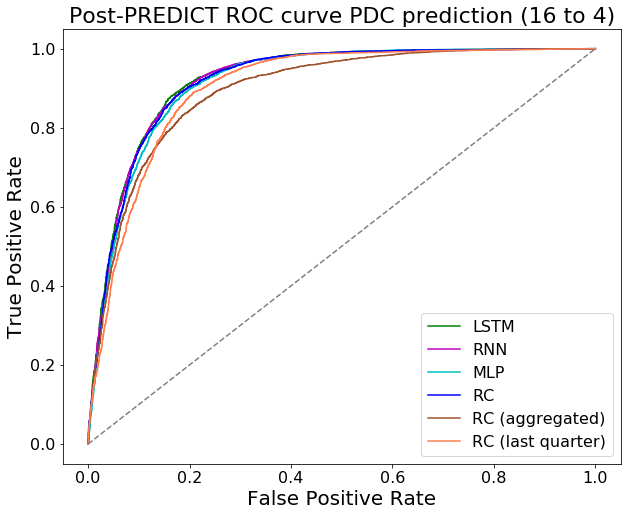

In [5]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
fs = 20
lstm_auc = roc_auc_score(y[:, 1], 
                         lstm_yhat[:, 1])
rnn_auc = roc_auc_score(y[:, 1],
                         rnn_yhat[:, 1])
mlp_auc = roc_auc_score(y[:, 1],
                         mlp_yhat[:, 1])
lr_auc = roc_auc_score(y[:, 1], 
                          lr_yhat[:, 0])
lr_a_auc = roc_auc_score(y[:, 1], 
                          lr_a_yhat[:, 0])
lr_l_auc = roc_auc_score(y[:, 1], 
                          lr_l_yhat[:, 0])
print('LSTM:\t\t\tROC AUC = %.3f' % (lstm_auc))
print('RNN:\t\t\tROC AUC = %.3f' %(rnn_auc))
print('MLP:\t\t\tROC AUC = %.3f' %(mlp_auc))
print('RC:\t\t\tROC AUC = %.3f' %(lr_auc))
print('RC (aggregated):\tROC AUC = %.3f' %(lr_a_auc))
print('RC (last quarter):\tROC AUC = %.3f' %(lr_l_auc))

lstm_fp, lstm_tp, _ = roc_curve(y[:, 1], 
                                lstm_yhat[:, 1])
rnn_fp, rnn_tp, _ = roc_curve(y[:, 1], 
                              rnn_yhat[:, 1])
mlp_fp, mlp_tp, _ = roc_curve(y[:, 1], 
                              mlp_yhat[:, 1])
lr_fp, lr_tp, _ = roc_curve(y[:, 1], 
                            lr_yhat[:, 0])
lr_a_fp, lr_a_tp, _ = roc_curve(y[:, 1], 
                            lr_a_yhat[:, 0])
lr_l_fp, lr_l_tp, _ = roc_curve(y[:, 1], 
                            lr_l_yhat[:, 0])

pyplot.rcParams.update({'font.size':16})
pyplot.figure(figsize=(10,8))
pyplot.plot(lstm_fp, lstm_tp, color='g', 
            linestyle='-', label='LSTM')
pyplot.plot(rnn_fp, rnn_tp, color='m', 
            linestyle='-', label='RNN')
pyplot.plot(mlp_fp, mlp_tp, color='c', 
             linestyle='-', label='MLP')
pyplot.plot(lr_fp, lr_tp, color='b', 
             linestyle='-', label='RC')
pyplot.plot(lr_a_fp, lr_a_tp, color='sienna', 
             linestyle='-', label='RC (aggregated)')
pyplot.plot(lr_l_fp, lr_l_tp, color='coral', 
             linestyle='-', label='RC (last quarter)')

pyplot.plot([0, 1], [0, 1], color='grey', linestyle='--')
pyplot.title('Post-PREDICT ROC curve PDC prediction (16 to 4)', fontsize=fs*1.1)
pyplot.xlabel('False Positive Rate', fontsize=fs)
pyplot.ylabel('True Positive Rate', fontsize=fs)
pyplot.legend(fontsize=fs*0.8)
filename = "/home/whsu014/plots/Post_PREDICT_PDC_(16to4)_ROC_Curves.png"
pyplot.savefig(filename)
pyplot.show()

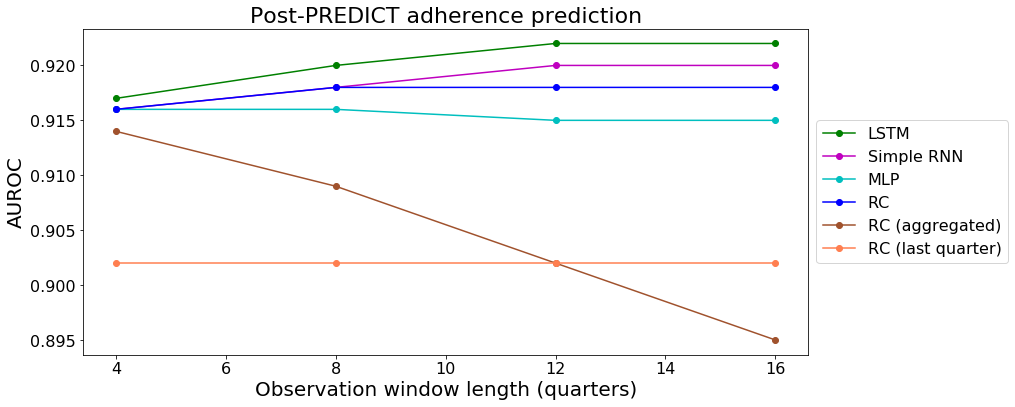

In [4]:
pyplot.rcParams.update({'font.size':16})
pyplot.figure(figsize=(13,6))
fs = 20
pyplot.plot([4,8,12,16], [0.917,0.920, 0.922, 0.922], color='g', 
            linestyle='-', marker='o', label='LSTM')
pyplot.plot([4,8,12,16], [0.916, 0.918, 0.920, 0.920], color='m', 
            linestyle='-', marker='o', label='Simple RNN')
pyplot.plot([4,8,12,16], [0.916, 0.916, 0.915, 0.915], color='c', 
             linestyle='-', marker='o', label='MLP')
pyplot.plot([4,8,12,16], [0.916, 0.918, 0.918, 0.918], color='b', 
             linestyle='-', marker='o', label='RC')
pyplot.plot([4,8,12,16], [0.914, 0.909,0.902, 0.895] , color='sienna', 
             linestyle='-', marker='o', label='RC (aggregated)')
pyplot.plot([4,8,12,16], [0.902, 0.902, 0.902, 0.902], color='coral', 
             linestyle='-', marker='o', label='RC (last quarter)')

pyplot.title('Post-PREDICT adherence prediction', fontsize=fs*1.1)
pyplot.xlabel('Observation window length (quarters)', fontsize=fs)
pyplot.ylabel('AUROC', fontsize=fs)
pyplot.legend(loc='center left', bbox_to_anchor=(1, 0.5),fontsize=fs*0.8)
filename = "/home/whsu014/plots/Post_PREDICT_Adherence_Prediction_AUROC.png"
pyplot.savefig(filename, bbox_inches='tight')
pyplot.show()